In [ ]:
import numpy as np
import pandas as pd
import datetime
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns #test 17136

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/2021KPI/2021KPItrain.xlsx', index_col=0)

In [ ]:
df['start_time']=pd.to_datetime(df['start_time'])
df['year'] = df['start_time'].dt.year
df['month'] = df['start_time'].dt.month
df['day'] = df['start_time'].dt.day
df['weekday']=df['start_time'].dt.weekday+1
df['hour']=df['start_time'].dt.hour
df['weekend']=(df['weekday']>=5).astype(int)
df['daylight']=((df['hour'] >= 20) | (df['hour'] <= 7)).astype(int)

In [ ]:
le=LabelEncoder()
df['kpi_id']=le.fit_transform(df['kpi'])

In [ ]:
pd.crosstab(df.label,"counts")

col_0,counts
label,
0,104258
1,1006


In [ ]:
df.sort_values(['kpi_id','start_time'],inplace=True)

In [ ]:
df.reset_index(drop=True,inplace=True)

In [ ]:
df = df.drop(df[df['value']=='NIL'].index)

In [ ]:
cols_win = ['value']
for col in cols_win:
    df['win_2_mean_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=2,min_periods=1).mean().reset_index(0,drop=True)
    
    df['win_3_mean_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=3,min_periods=2).mean().reset_index(0,drop=True)

    df['win_6_mean_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).mean().reset_index(0,drop=True)
    df['win_6_std_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).std().reset_index(0,drop=True)
    df['win_6_skew_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).skew().reset_index(0,drop=True)
    df['win_6_kurt_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).kurt().reset_index(0,drop=True)
    df['win_6_q25_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).quantile(0.25).reset_index(0,drop=True)
    df['win_6_q50_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).quantile(0.50).reset_index(0,drop=True)
    df['win_6_q75_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=6,min_periods=3).quantile(0.75).reset_index(0,drop=True)
    
    df['win_12_mean_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).mean().reset_index(0,drop=True)
    df['win_12_std_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).std().reset_index(0,drop=True)
    df['win_12_skew_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).skew().reset_index(0,drop=True)
    df['win_12_kurt_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).kurt().reset_index(0,drop=True)
    df['win_12_q25_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).quantile(0.25).reset_index(0,drop=True)
    df['win_12_q50_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).quantile(0.50).reset_index(0,drop=True)
    df['win_12_q75_{}'.format(col)]= df.groupby("kpi")[col].rolling(window=12,min_periods=6).quantile(0.75).reset_index(0,drop=True)

In [ ]:
cols_shift=['value','win_2_mean_value','win_3_mean_value']
#差分
for col in cols_shift:
    for i in [1,24,48,144,168]:
        cc="shift_{}_{}".format(col,i)
        df[cc] = df.groupby('kpi_id')[col].shift(i)
        df['x_y_{}_{}'.format(col,i)]=np.abs(df[col]-df[cc])
        #df['xy_{}_{}'.format(col,i)]=df[col]/df[cc]
        df.drop(cc,axis=1,inplace=True)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df.value = df.value.apply(pd.to_numeric)
#趨勢和週期特徵
df['expa_mean']=df.groupby(["kpi_id"])['value'].expanding().mean().reset_index(drop=True)
df['expa_std']=df.groupby(["kpi_id"])['value'].expanding().std().reset_index(drop=True)
df['win_3_mean']= df.groupby("kpi_id")['value'].rolling(window=3,min_periods=3).mean().reset_index(0,drop=True)
df['trend_win3']=df['value']-df['win_3_mean']
df['z_score']=(df['win_3_mean']-(df.groupby("kpi_id")['value'].transform('mean')))/df.groupby("kpi_id")['value'].transform('std')

In [ ]:
#刪除na值
df = df[df['x_y_value_168'].notnull()]
df.reset_index(drop=True,inplace=True)
#剩88126筆資料 

In [ ]:
df.fillna(0,inplace=True)

In [ ]:
open_time = '2019-01-21'
close_time = '2019-01-28'
filter0 = df['start_time'] < open_time
filter1 = df['start_time'] >= open_time
filter2 = df['start_time'] < close_time
df_train = df[filter0] #88128筆
df_test = df[filter1&filter2] #17136筆

In [ ]:
df.drop(['start_time','kpi'],axis=1,inplace=True)
df

,value,label,year,month,day,weekday,hour,weekend,daylight,kpi_id,win_2_mean_value,win_3_mean_value,win_6_mean_value,win_6_std_value,win_6_skew_value,win_6_kurt_value,win_6_q25_value,win_6_q50_value,win_6_q75_value,win_12_mean_value,win_12_std_value,win_12_skew_value,win_12_kurt_value,win_12_q25_value,win_12_q50_value,win_12_q75_value,x_y_value_1,x_y_value_24,x_y_value_48,x_y_value_144,x_y_value_168,x_y_win_2_mean_value_1,x_y_win_2_mean_value_24,x_y_win_2_mean_value_48,x_y_win_2_mean_value_144,x_y_win_2_mean_value_168,x_y_win_3_mean_value_1,x_y_win_3_mean_value_24,x_y_win_3_mean_value_48,x_y_win_3_mean_value_144,x_y_win_3_mean_value_168,expa_mean,expa_std,win_3_mean,trend_win3,z_score
0,41062.0,0,2018,12,23,7,0,1,1,0,41344.5,41522.000000,41946.500000,561.820167,-0.492438,0.196486,41689.50,42010.5,42258.00,42207.416667,489.034942,-1.258341,1.550799,42077.25,42266.5,42547.75,565.0,30.0,84.0,633.0,7346.0,407.5,54.5,234.5,488.0,7063.5,360.666667,78.333333,292.666667,505.333333,0.000000,42281.207101,1060.623002,41522.000000,-460.000000,1.038317
1,40928.0,0,2018,12,23,7,1,1,1,0,40995.0,41205.666667,41655.666667,562.182414,-0.345635,-1.821184,41203.25,41752.0,42077.25,42098.333333,612.294393,-0.987645,-0.105631,41814.50,42243.0,42547.75,134.0,0.0,88.0,353.0,6529.0,349.5,15.0,86.0,493.0,6937.5,316.333333,36.333333,185.666667,443.000000,6726.833333,42273.247059,1062.561245,41205.666667,-277.666667,0.961162
2,40915.0,0,2018,12,23,7,2,1,1,0,40921.5,40968.333333,41425.500000,529.328915,0.337669,-2.180977,40961.50,41344.5,41814.50,41992.083333,699.373415,-0.639919,-1.237153,41485.75,42220.0,42547.75,13.0,2.0,14.0,296.0,5857.0,73.5,1.0,37.0,324.5,6193.0,237.333333,9.333333,52.666667,427.333333,6577.333333,42265.304094,1064.510929,40968.333333,-53.333333,0.903275
3,40846.0,0,2018,12,23,7,3,1,1,0,40880.5,40896.333333,41209.166667,433.525739,1.001611,-1.077779,40918.25,40995.0,41485.75,41851.250000,748.331978,-0.269897,-1.741423,41028.50,42010.5,42523.00,69.0,4.0,16.0,273.0,5327.0,41.0,3.0,15.0,284.5,5592.0,72.000000,2.000000,19.333333,307.333333,5904.333333,42257.052326,1066.896660,40896.333333,-50.333333,0.885714
4,40800.0,0,2018,12,23,7,4,1,1,0,40823.0,40853.666667,41029.666667,305.881459,2.015751,4.266029,40863.25,40921.5,41028.50,41702.666667,766.619063,0.080060,-1.829722,40924.75,41752.0,42347.75,46.0,5.0,2.0,286.0,3180.0,57.5,4.5,7.0,279.5,4253.5,42.666667,3.666667,9.333333,285.000000,4788.000000,42248.630058,1069.543046,40853.666667,-53.666667,0.875307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88121,5634.0,0,2019,1,27,7,19,1,0,101,5831.0,5688.666667,5748.166667,481.669769,-0.491515,-1.009538,5461.50,5831.0,6075.25,6121.000000,826.508318,0.579764,-0.595142,5411.50,6059.5,6534.75,394.0,279.0,524.0,1877.0,2044.0,115.0,79.5,228.0,1181.5,1473.0,224.000000,23.666667,122.666667,1360.333333,2225.000000,6605.356311,1986.356774,5688.666667,-54.666667,-0.460024
88122,4582.0,0,2019,1,27,7,20,1,1,101,5108.0,5414.666667,5496.666667,636.070017,-0.218651,-0.869509,5120.50,5519.0,5929.50,5891.666667,841.011440,0.562693,0.361606,5381.75,5831.0,6339.50,1052.0,587.0,1089.0,1066.0,2636.0,723.0,154.0,806.5,1471.5,2340.0,274.000000,248.666667,211.000000,1143.000000,1860.666667,6603.498545,1986.288203,5414.666667,-832.666667,-0.598005
88123,5635.0,0,2019,1,27,7,21,1,1,101,5108.5,5283.666667,5598.166667,593.080236,-0.895134,1.404043,5461.50,5634.5,5929.75,5724.500000,636.087258,-0.005872,-0.348739,5381.75,5634.5,6144.75,1053.0,27.0,1121.0,1728.0,315.0,0.5,280.0,16.0,1397.0,1475.5,131.000000,93.666667,164.000000,1557.000000,1665.000000,6602.173450,1985.781000,5283.666667,351.333333,-0.663974
88124,4690.0,0,2019,1,27,7,22,1,1,101,5162.5,4969.000000,5328.833333,573.971573,-0.440973,-1.515318,4868.50,5519.0,5634.75,5578.666667,657.385916,0.241807,-0.264783,5242.75,5524.0,6043.75,945.0,63.0,983.0,835.0,3373.0,54.0,18.0,69.

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

In [ ]:
df_train.drop(['start_time','kpi'],axis=1,inplace=True)
df_test.drop(['start_time','kpi'],axis=1,inplace=True)

In [ ]:
train = df_train
train[:] = np.nan_to_num(df_train)

In [ ]:
train_y = train['label']
train_x = train.drop('label',axis=1)

In [ ]:
train_x.iloc[:,1:9]

,year,month,day,weekday,hour,weekend,daylight,kpi_id
0,2018.0,12.0,23.0,7.0,0.0,1.0,1.0,0.0
1,2018.0,12.0,23.0,7.0,1.0,1.0,1.0,0.0
2,2018.0,12.0,23.0,7.0,2.0,1.0,1.0,0.0
3,2018.0,12.0,23.0,7.0,3.0,1.0,1.0,0.0
4,2018.0,12.0,23.0,7.0,4.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...
87953,2019.0,1.0,20.0,7.0,19.0,1.0,0.0,101.0
87954,2019.0,1.0,20.0,7.0,20.0,1.0,1.0,101.0
87955,2019.0,1.0,20.0,7.0,21.0,1.0,1.0,101.0
87956,2019.0,1.0,20.0,7.0,22.0,1.0,1.0,101.0


In [ ]:
smo = SMOTENC(random_state=42,categorical_features=[1,2,3,4,5,6,7,8])
X_smo, y_smo = smo.fit_resample(train_x,train_y)
X_smo2 = pd.DataFrame(X_smo, columns=train_x.columns.values)
train_x = X_smo2.reset_index(drop=True)
train_x

,value,year,month,day,weekday,hour,weekend,daylight,kpi_id,win_2_mean_value,win_3_mean_value,win_6_mean_value,win_6_std_value,win_6_skew_value,win_6_kurt_value,win_6_q25_value,win_6_q50_value,win_6_q75_value,win_12_mean_value,win_12_std_value,win_12_skew_value,win_12_kurt_value,win_12_q25_value,win_12_q50_value,win_12_q75_value,x_y_value_1,x_y_value_24,x_y_value_48,x_y_value_144,x_y_value_168,x_y_win_2_mean_value_1,x_y_win_2_mean_value_24,x_y_win_2_mean_value_48,x_y_win_2_mean_value_144,x_y_win_2_mean_value_168,x_y_win_3_mean_value_1,x_y_win_3_mean_value_24,x_y_win_3_mean_value_48,x_y_win_3_mean_value_144,x_y_win_3_mean_value_168,expa_mean,expa_std,win_3_mean,trend_win3,z_score
0,41062.000000,2018.0,12.0,23.0,7.0,0.0,1.0,1.0,0.0,41344.500000,41522.000000,41946.500000,561.820167,-0.492438,0.196486,41689.500000,42010.500000,42258.000000,42207.416667,489.034942,-1.258341,1.550799,42077.250000,42266.500000,42547.750000,565.000000,30.000000,84.000000,633.000000,7346.000000,407.500000,54.500000,234.500000,488.000000,7063.500000,360.666667,78.333333,292.666667,505.333333,0.000000,42281.207101,1060.623002,41522.000000,-460.000000,1.038317
1,40928.000000,2018.0,12.0,23.0,7.0,1.0,1.0,1.0,0.0,40995.000000,41205.666667,41655.666667,562.182414,-0.345635,-1.821184,41203.250000,41752.000000,42077.250000,42098.333333,612.294393,-0.987645,-0.105631,41814.500000,42243.000000,42547.750000,134.000000,0.000000,88.000000,353.000000,6529.000000,349.500000,15.000000,86.000000,493.000000,6937.500000,316.333333,36.333333,185.666667,443.000000,6726.833333,42273.247059,1062.561245,41205.666667,-277.666667,0.961162
2,40915.000000,2018.0,12.0,23.0,7.0,2.0,1.0,1.0,0.0,40921.500000,40968.333333,41425.500000,529.328915,0.337669,-2.180977,40961.500000,41344.500000,41814.500000,41992.083333,699.373415,-0.639919,-1.237153,41485.750000,42220.000000,42547.750000,13.000000,2.000000,14.000000,296.000000,5857.000000,73.500000,1.000000,37.000000,324.500000,6193.000000,237.333333,9.333333,52.666667,427.333333,6577.333333,42265.304094,1064.510929,40968.333333,-53.333333,0.903275
3,40846.000000,2018.0,12.0,23.0,7.0,3.0,1.0,1.0,0.0,40880.500000,40896.333333,41209.166667,433.525739,1.001611,-1.077779,40918.250000,40995.000000,41485.750000,41851.250000,748.331978,-0.269897,-1.741423,41028.500000,42010.500000,42523.000000,69.000000,4.000000,16.000000,273.000000,5327.000000,41.000000,3.000000,15.000000,284.500000,5592.000000,72.000000,2.000000,19.333333,307.333333,5904.333333,42257.052326,1066.896660,40896.333333,-50.333333,0.885714
4,40800.000000,2018.0,12.0,23.0,7.0,4.0,1.0,1.0,0.0,40823.000000,40853.666667,41029.666667,305.881459,2.015751,4.266029,40863.250000,40921.500000,41028.500000,41702.666667,766.619063,0.080060,-1.829722,40924.750000,41752.000000,42347.750000,46.000000,5.000000,2.000000,286.000000,3180.000000,57.500000,4.500000,7.000000,279.500000,4253.500000,42.666667,3.666667,9.333333,285.000000,4788.000000,42248.630058,1069.543046,40853.666667,-53.666667,0.875307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140751,980.530954,2019.0,1.0,10.0,4.0,10.0,0.0,0.0,60.0,1400.720967,1648.859467,1339.139478,655.257780,-0.089253,-1.981911,882.258246,1368.082919,1802.090826,1013.698411,596.032223,0.878396,-0.624007,542.092974,825.530954,1338.519657,840.380026,590.511973,675.614549,471.493899,358.067780,582.302756,242.441257,166.434703,70.020334,192.116585,252.809911,588.925140,195.439977,175.781594,556.254708,1297.537903,557.014190,1648.859467,-668.328513,0.602373
140752,34.024575,2019.0,1.0,7.0,1.0,5.0,0.0,0.0,81.0,38.393982,40.059146,40.666410,5.718427,-1.613280,29.567628,40.701416,41.776184,43.165933,44.283057,7.737419,-0.569271,-7.168653,41.093075,43.748462,47.130831,10.671476,15.115342,12.391573,7.517272,9.638575,4.682450,7.832394,6.375894,2.481924,3.664574,3.276212,5.390387,4.456188,1.859363,3.563052,41.434021,10.487506,40.059146,-6

In [ ]:
y_smo = pd.DataFrame(y_smo, columns=['label'])
train_y=y_smo.reset_index(drop=True)
train_x.insert(1,'label',train_y)
train_x

,value,label,year,month,day,weekday,hour,weekend,daylight,kpi_id,win_2_mean_value,win_3_mean_value,win_6_mean_value,win_6_std_value,win_6_skew_value,win_6_kurt_value,win_6_q25_value,win_6_q50_value,win_6_q75_value,win_12_mean_value,win_12_std_value,win_12_skew_value,win_12_kurt_value,win_12_q25_value,win_12_q50_value,win_12_q75_value,x_y_value_1,x_y_value_24,x_y_value_48,x_y_value_144,x_y_value_168,x_y_win_2_mean_value_1,x_y_win_2_mean_value_24,x_y_win_2_mean_value_48,x_y_win_2_mean_value_144,x_y_win_2_mean_value_168,x_y_win_3_mean_value_1,x_y_win_3_mean_value_24,x_y_win_3_mean_value_48,x_y_win_3_mean_value_144,x_y_win_3_mean_value_168,expa_mean,expa_std,win_3_mean,trend_win3,z_score
0,41062.000000,0.0,2018.0,12.0,23.0,7.0,0.0,1.0,1.0,0.0,41344.500000,41522.000000,41946.500000,561.820167,-0.492438,0.196486,41689.500000,42010.500000,42258.000000,42207.416667,489.034942,-1.258341,1.550799,42077.250000,42266.500000,42547.750000,565.000000,30.000000,84.000000,633.000000,7346.000000,407.500000,54.500000,234.500000,488.000000,7063.500000,360.666667,78.333333,292.666667,505.333333,0.000000,42281.207101,1060.623002,41522.000000,-460.000000,1.038317
1,40928.000000,0.0,2018.0,12.0,23.0,7.0,1.0,1.0,1.0,0.0,40995.000000,41205.666667,41655.666667,562.182414,-0.345635,-1.821184,41203.250000,41752.000000,42077.250000,42098.333333,612.294393,-0.987645,-0.105631,41814.500000,42243.000000,42547.750000,134.000000,0.000000,88.000000,353.000000,6529.000000,349.500000,15.000000,86.000000,493.000000,6937.500000,316.333333,36.333333,185.666667,443.000000,6726.833333,42273.247059,1062.561245,41205.666667,-277.666667,0.961162
2,40915.000000,0.0,2018.0,12.0,23.0,7.0,2.0,1.0,1.0,0.0,40921.500000,40968.333333,41425.500000,529.328915,0.337669,-2.180977,40961.500000,41344.500000,41814.500000,41992.083333,699.373415,-0.639919,-1.237153,41485.750000,42220.000000,42547.750000,13.000000,2.000000,14.000000,296.000000,5857.000000,73.500000,1.000000,37.000000,324.500000,6193.000000,237.333333,9.333333,52.666667,427.333333,6577.333333,42265.304094,1064.510929,40968.333333,-53.333333,0.903275
3,40846.000000,0.0,2018.0,12.0,23.0,7.0,3.0,1.0,1.0,0.0,40880.500000,40896.333333,41209.166667,433.525739,1.001611,-1.077779,40918.250000,40995.000000,41485.750000,41851.250000,748.331978,-0.269897,-1.741423,41028.500000,42010.500000,42523.000000,69.000000,4.000000,16.000000,273.000000,5327.000000,41.000000,3.000000,15.000000,284.500000,5592.000000,72.000000,2.000000,19.333333,307.333333,5904.333333,42257.052326,1066.896660,40896.333333,-50.333333,0.885714
4,40800.000000,0.0,2018.0,12.0,23.0,7.0,4.0,1.0,1.0,0.0,40823.000000,40853.666667,41029.666667,305.881459,2.015751,4.266029,40863.250000,40921.500000,41028.500000,41702.666667,766.619063,0.080060,-1.829722,40924.750000,41752.000000,42347.750000,46.000000,5.000000,2.000000,286.000000,3180.000000,57.500000,4.500000,7.000000,279.500000,4253.500000,42.666667,3.666667,9.333333,285.000000,4788.000000,42248.630058,1069.543046,40853.666667,-53.666667,0.875307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140751,980.530954,1.0,2019.0,1.0,10.0,4.0,10.0,0.0,0.0,60.0,1400.720967,1648.859467,1339.139478,655.257780,-0.089253,-1.981911,882.258246,1368.082919,1802.090826,1013.698411,596.032223,0.878396,-0.624007,542.092974,825.530954,1338.519657,840.380026,590.511973,675.614549,471.493899,358.067780,582.302756,242.441257,166.434703,70.020334,192.116585,252.809911,588.925140,195.439977,175.781594,556.254708,1297.537903,557.014190,1648.859467,-668.328513,0.602373
140752,34.024575,1.0,2019.0,1.0,7.0,1.0,5.0,0.0,0.0,81.0,38.393982,40.059146,40.666410,5.718427,-1.613280,29.567628,40.701416,41.776184,43.165933,44.283057,7.737419,-0.569271,-7.168653,41.093075,43.748462,47.130831,10.671476,15.115342,12.391573,7.517272,9.638575,4.682450,7.832394,6.375894,2.481924,3.664574,3.276212,5.390387,4.456188,1.859363,3.5

In [ ]:
pd.crosstab(train_x.label,"counts")

col_0,counts
label,
0.0,70378
1.0,70378


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

In [ ]:
f1_s = []
model = RandomForestClassifier(n_estimators=200, random_state=0,)
for i in range(0,102):
  model.fit(df[df['kpi_id'] == i].drop(['label'],axis = 1), df[df['kpi_id'] == i].label)
  pre2 = model.predict(df[df['kpi_id'] == i].drop(['label'],axis = 1))
  f1_s.append(f1_score(df[df['kpi_id'] == i].label, pre2))
print(f1_s)

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]


In [ ]:
def get_index1(lst, item):
  return [index for (index,value) in enumerate(lst) if value >= item]

In [ ]:
board_index = get_index1(f1_s, 1)

In [ ]:
len(board_index)

86

In [ ]:
board_kpi_train = pd.DataFrame()
for a in board_index:
  board_kpi_train = pd.concat([board_kpi_train, df_train[df_train["kpi_id"] == a]], axis=0)
board_kpi_train #74304筆 #59856筆

,value,label,year,month,day,weekday,hour,weekend,daylight,kpi_id,win_2_mean_value,win_3_mean_value,win_6_mean_value,win_6_std_value,win_6_skew_value,win_6_kurt_value,win_6_q25_value,win_6_q50_value,win_6_q75_value,win_12_mean_value,win_12_std_value,win_12_skew_value,win_12_kurt_value,win_12_q25_value,win_12_q50_value,win_12_q75_value,x_y_value_1,x_y_value_24,x_y_value_48,x_y_value_144,x_y_value_168,x_y_win_2_mean_value_1,x_y_win_2_mean_value_24,x_y_win_2_mean_value_48,x_y_win_2_mean_value_144,x_y_win_2_mean_value_168,x_y_win_3_mean_value_1,x_y_win_3_mean_value_24,x_y_win_3_mean_value_48,x_y_win_3_mean_value_144,x_y_win_3_mean_value_168,expa_mean,expa_std,win_3_mean,trend_win3,z_score
864,80.273,0.0,2018.0,12.0,23.0,7.0,0.0,1.0,1.0,1.0,80.4495,80.922333,81.111333,0.858171,0.029487,17539.507718,80.36125,81.1135,81.80125,80.994917,0.752902,0.278509,-15937.433101,80.53775,80.8310,81.66775,0.353,0.770,0.194,0.758,4.790,0.7975,0.9010,0.1705,0.3395,4.9665,0.035000,1.004667,0.365000,0.116000,0.000000,78.510627,4.559705,80.922333,-0.649333,0.377609
865,78.125,0.0,2018.0,12.0,23.0,7.0,1.0,1.0,1.0,1.0,79.1990,79.674667,80.443500,1.332869,-1.019912,3016.067466,80.19425,80.4495,81.35725,80.847667,1.086917,-1.310675,-3666.189872,80.53775,80.8310,81.66775,2.148,1.381,2.461,0.775,0.536,1.2505,1.0755,1.1335,0.0085,2.1270,1.247667,1.061000,0.706667,0.032000,2.602667,78.508359,4.546291,79.674667,-1.549667,0.267561
866,69.620,0.0,2018.0,12.0,23.0,7.0,2.0,1.0,1.0,1.0,73.8725,76.006000,78.446667,4.489254,-2.076194,27.945865,78.63575,80.2205,80.53775,79.908583,3.417489,-2.894206,-28.537923,80.24675,80.7060,81.66775,8.505,8.951,6.803,5.568,4.995,5.3265,3.7850,2.1710,2.3965,2.7655,3.668667,2.266667,1.512000,1.850333,0.247000,78.456380,4.583578,76.006000,-6.386000,-0.056029
867,74.038,0.0,2018.0,12.0,23.0,7.0,3.0,1.0,1.0,1.0,71.8290,73.927667,77.425000,4.711211,-1.062606,19.319631,75.05975,79.1990,80.53775,79.347333,3.794830,-1.982351,-21.171466,79.65725,80.6325,81.66775,4.418,2.804,1.256,2.128,0.125,2.0435,5.8775,4.0295,1.7200,2.4350,2.078333,3.458000,1.866000,0.888333,1.802000,78.430692,4.582556,73.927667,0.110333,-0.239346
868,75.610,0.0,2018.0,12.0,23.0,7.0,4.0,1.0,1.0,1.0,74.8240,73.089333,76.382000,4.195340,-0.738981,30.527045,74.43100,76.8675,79.73600,78.928250,3.915003,-1.517200,-20.090915,77.49625,80.4495,81.66775,1.572,0.610,1.723,3.321,2.312,2.9950,1.0970,1.4895,2.7245,1.0935,0.838333,3.715000,3.260667,0.039667,2.394000,78.414387,4.574245,73.089333,2.520667,-0.313290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87953,7678.000,0.0,2019.0,1.0,20.0,7.0,19.0,1.0,0.0,101.0,7304.0000,7913.666667,7399.166667,928.183477,1.636273,2.929373,6956.75000,7070.5000,7534.50000,7626.333333,1037.837904,1.364073,1.458806,7010.25000,7226.0000,8000.00000,748.000,79.000,228.000,293.000,296.000,727.5000,196.5000,31.5000,680.0000,217.5000,213.666667,351.333333,150.333333,101.000000,451.333333,6825.783063,1942.777692,7913.666667,-235.666667,0.660442
87954,7218.000,0.0,2019.0,1.0,20.0,7.0,20.0,1.0,1.0,101.0,7448.0000,7275.333333,7516.666667,833.344507,1.979031,3.959968,7053.75000,7161.0000,7563.00000,7393.583333,718.471415,1.313371,2.118168,7010.25000,7208.5000,7758.25000,460.000,810.000,1005.000,583.000,640.000,144.0000,444.5000,388.5000,145.0000,468.0000,638.333333,139.000000,356.000000,259.000000,68.333333,6827.216686,1942.107161,7275.333333,-57.333333,0.338990
87955,5950.000,0.0,2019.0,1.0,20.0,7.0,21.0,1.0,1.0,101.0,6584.0000,6948.666667,7324.333333,1052.094419,0.844643,1.928753,6956.75000,7127.5000,7563.00000,7222.500000,799.972897,1.044892,2.398391,6861.50000,7151.5000,7359.25000,1268.000,1161.000,730.000,2066.000,1110.000,864.0000,175.5000,137.5000,741.5000,235.0000,326.666667,90.666667,15.666667,592.000000,58.000000,6826.133102,1941.242940,6948.666667,-998.666667,0.174487
87956,8063.000,0.0,2019.0,1.0,20.0,7.0,22.0,1.

In [ ]:
board_kpi_test = pd.DataFrame()
for a in board_index:
  board_kpi_test = pd.concat([board_kpi_test, df_test[df_test["kpi_id"] == a]], axis=0)
board_kpi_test #14448筆 

,value,label,year,month,day,weekday,hour,weekend,daylight,kpi_id,win_2_mean_value,win_3_mean_value,win_6_mean_value,win_6_std_value,win_6_skew_value,win_6_kurt_value,win_6_q25_value,win_6_q50_value,win_6_q75_value,win_12_mean_value,win_12_std_value,win_12_skew_value,win_12_kurt_value,win_12_q25_value,win_12_q50_value,win_12_q75_value,x_y_value_1,x_y_value_24,x_y_value_48,x_y_value_144,x_y_value_168,x_y_win_2_mean_value_1,x_y_win_2_mean_value_24,x_y_win_2_mean_value_48,x_y_win_2_mean_value_144,x_y_win_2_mean_value_168,x_y_win_3_mean_value_1,x_y_win_3_mean_value_24,x_y_win_3_mean_value_48,x_y_win_3_mean_value_144,x_y_win_3_mean_value_168,expa_mean,expa_std,win_3_mean,trend_win3,z_score
1560,79.696,0,2019,1,21,1,0,0,1,1,80.4975,80.512333,80.711667,0.797627,-0.295882,23503.790311,80.05300,80.874,81.27575,80.952083,0.719389,-0.144318,-19119.695774,80.57725,81.0190,81.34300,1.603,0.616,0.193,0.728,73.923,0.4230,0.0285,0.9065,0.0035,67.1290,0.064667,0.426667,0.598000,0.265333,44.443667,77.078096,10.031605,80.512333,-0.816333,0.341446
1561,76.103,0,2019,1,21,1,1,0,1,1,77.8995,79.032667,79.789333,1.921480,-1.834952,701.692398,79.74450,80.216,81.04000,80.561667,1.576830,-2.274942,-821.995217,80.37900,81.0190,81.34300,3.593,2.022,0.856,2.374,1.344,2.5980,1.3190,0.3315,1.5510,36.2895,1.479667,0.655000,0.319000,0.793667,44.304667,77.076970,10.025860,79.032667,-2.929667,0.210934
1562,73.054,0,2019,1,21,1,2,0,1,1,74.5785,76.284333,78.430667,3.185666,-1.205465,92.652873,77.00125,79.793,80.37900,79.859917,2.645266,-2.000871,-100.894615,79.84150,80.8030,81.22925,3.049,3.679,5.517,5.559,2.134,3.3210,0.8285,3.1865,3.9665,1.7390,2.748333,0.347000,2.060000,2.887000,23.481667,77.072330,10.021001,76.284333,-3.230333,-0.031479
1563,79.000,0,2019,1,21,1,3,0,1,1,76.0270,76.052333,78.282333,3.124254,-1.092872,100.097358,76.82725,79.348,80.33050,79.691500,2.628908,-1.820699,-104.048866,79.52200,80.5655,81.22925,5.946,18.335,2.158,2.077,7.090,1.4485,7.3280,1.6795,1.7410,2.4780,0.232000,5.559333,1.405000,1.952000,1.204000,77.074551,10.015434,76.052333,2.947667,-0.051942
1564,77.528,0,2019,1,21,1,4,0,1,1,78.2640,76.527333,77.780000,2.924165,-0.694335,130.348082,76.45925,78.264,79.52200,79.436417,2.681878,-1.432759,-97.195134,78.63200,80.2160,81.22925,1.472,19.271,71.651,1.996,4.909,2.2370,18.8030,36.9045,2.0365,5.9995,0.475000,11.309000,22.764000,0.495333,3.288333,77.075072,10.009675,76.527333,1.000667,-0.010046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88121,5634.000,0,2019,1,27,7,19,1,0,101,5831.0000,5688.666667,5748.166667,481.669769,-0.491515,-1.009538,5461.50000,5831.000,6075.25000,6121.000000,826.508318,0.579764,-0.595142,5411.50000,6059.5000,6534.75000,394.000,279.000,524.000,1877.000,2044.000,115.0000,79.5000,228.0000,1181.5000,1473.0000,224.000000,23.666667,122.666667,1360.333333,2225.000000,6605.356311,1986.356774,5688.666667,-54.666667,-0.460024
88122,4582.000,0,2019,1,27,7,20,1,1,101,5108.0000,5414.666667,5496.666667,636.070017,-0.218651,-0.869509,5120.50000,5519.000,5929.50000,5891.666667,841.011440,0.562693,0.361606,5381.75000,5831.0000,6339.50000,1052.000,587.000,1089.000,1066.000,2636.000,723.0000,154.0000,806.5000,1471.5000,2340.0000,274.000000,248.666667,211.000000,1143.000000,1860.666667,6603.498545,1986.288203,5414.666667,-832.666667,-0.598005
88123,5635.000,0,2019,1,27,7,21,1,1,101,5108.5000,5283.666667,5598.166667,593.080236,-0.895134,1.404043,5461.50000,5634.500,5929.75000,5724.500000,636.087258,-0.005872,-0.348739,5381.75000,5634.5000,6144.75000,1053.000,27.000,1121.000,1728.000,315.000,0.5000,280.0000,16.0000,1397.0000,1475.5000,131.000000,93.666667,164.000000,1557.000000,1665.000000,6602.173450,1985.781000,5283.666667,351.333333,-0.663974
88124,4690.000,0,2019,1,27,7,22,1,1,101,5162.5000,4969.000000,5328.833333,573.971573,-0.440973,-1.515318,4868.50000,5519.000,5634.75000,5578.666667,657.3

In [ ]:
board_train_X = board_kpi_train.drop('label', axis=1)
board_train_Y = board_kpi_train['label']
board_test_X = board_kpi_test.drop('label', axis=1) #14448筆test data
board_test_Y = board_kpi_test['label'] #394個異常data

In [ ]:
f1_s2 = []
for i in board_index:
  model2 = RandomForestClassifier(random_state=2023,)
  model2.fit(df_train[df_train['kpi_id'] == i].drop(['label'],axis = 1), df_train[df_train['kpi_id'] == i].label)
  pre = model2.predict(df_test[df_test['kpi_id'] == i].drop(['label'],axis = 1))
  f1_s2.append(f1_score(df_test[df_test['kpi_id'] == i].label, pre)) 
print(f1_s2)

[0.9523809523809523, 1.0, 0.6666666666666666, 0.8571428571428571, 0.0, 0.0, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.0, 1.0, 1.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.5882352941176471, 0.3076923076923077, 0.0, 0.5882352941176471, 0.7368421052631579, 0.8, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 1.0, 0.8, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.8, 1.0, 0.0, 0.0, 0.0, 0.6666666666666666, 0.8, 0.0, 0.0, 0.3333333333333333, 0.6, 0.4, 0.5333333333333333, 1.0, 0.0, 0.0, 0.6666666666666666, 1.0, 0.0, 0.0, 0.6666666666666666, 0.0, 0.0, 0.888888888888889, 0.0, 0.0, 0.8571428571428571, 0.4, 0.5882352941176471, 0.0, 0.0, 0.8, 0.6666666666666666, 0.0, 0.923076923076923, 1.0, 0.9090909090909091, 0.888888888888889, 0.923076923076923, 1.0, 0.9411764705882353, 0.8571428571428571, 0.6666666666666666, 0.0, 0.0]


In [ ]:
board_index2 = get_index1(f1_s2, 0.9)
print(board_index2) #[0, 1, 32, 47, 64, 65, 66, 68, 69]
#[0, 1, 12, 13, 28, 30, 31, 35, 36, 37, 39, 42, 54, 58, 75, 76, 77, 79, 80, 81]

[0, 1, 12, 13, 28, 30, 31, 35, 36, 37, 39, 42, 54, 58, 75, 76, 77, 79, 80, 81]


In [ ]:
model2 = RandomForestClassifier(n_estimators=200, random_state=0,)
model2.fit(board_train_X, board_train_Y)
pre = model2.predict(board_test_X)
print(f1_score(board_test_Y, pre))

0.707165109034268


In [ ]:
pre3 = model2.predict(board_train_X)
print(f1_score(board_train_Y, pre3))

1.0


In [ ]:
!pip install catboost
from catboost import  CatBoostClassifier ,Pool

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [ ]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'verbose': 50,#200
          'random_seed': 2021
          #'learning_rate': 0.03
         }

In [ ]:
f1_s3 = []
model1 = CatBoostClassifier(**params)
for i in board_index:
  model1.fit(df_train[df_train['kpi_id'] == i].drop(['label'],axis = 1), df_train[df_train['kpi_id'] == i].label)
  pre2 = model1.predict(df_test[df_test['kpi_id'] == i].drop(['label'],axis = 1))
  f1_s3.append(f1_score(df_test[df_test['kpi_id'] == i].label, pre2))
print(f1_s3)

In [ ]:
board_index3 = get_index1(f1_s3, 0.9)
print(board_index3) #[0, 1, 12, 13, 23, 28, 29, 30, 31, 35, 36, 37, 39, 42, 54, 58, 67, 75, 76, 78, 79, 80, 81, 83]
#[0, 1, 3, 8, 9, 12, 13, 23, 24, 26, 28, 29, 30, 31, 35, 36, 37, 39, 42, 54, 58, 64, 67, 75, 76, 78, 79, 80, 81, 82]

[0, 1, 3, 8, 9, 12, 13, 23, 24, 26, 28, 29, 30, 31, 35, 36, 37, 39, 42, 54, 58, 64, 67, 75, 76, 78, 79, 80, 81, 82]


In [ ]:
board_index3 = [0, 1, 3, 8, 9, 12, 13, 23, 24, 26, 28, 29, 30, 31, 35, 36, 37, 39, 42, 54, 58, 64, 67, 75, 76, 78, 79, 80, 81, 82]

In [ ]:
board_index4 = []
for i in board_index3:
  board_index4.append(board_index[i])
print(board_index4)

[1, 2, 4, 11, 12, 15, 17, 28, 29, 32, 34, 35, 36, 37, 43, 44, 45, 47, 50, 63, 67, 73, 78, 90, 91, 93, 94, 95, 96, 97]


In [ ]:
kpi_value_test = df_test.groupby("kpi_id").sum().label
no_anomaly_test = kpi_value_test[kpi_value_test == 0].index
no_anomaly_test

Int64Index([ 0,  6,  7,  8, 16, 18, 21, 22, 30, 38, 39, 40, 42, 48, 62, 65, 69,
            71, 72, 74, 75, 80, 82, 83, 84, 85, 88, 89, 99],
           dtype='int64', name='kpi_id')

In [ ]:
zero_kpi_test = pd.DataFrame()
for a in no_anomaly_test:
  zero_kpi_test = pd.concat([zero_kpi_test, df_test[df_test["kpi_id"] == a]], axis=0)
zero_kpi_test #4872筆 

,value,label,year,month,day,weekday,hour,weekend,daylight,kpi_id,win_2_mean_value,win_3_mean_value,win_6_mean_value,win_6_std_value,win_6_skew_value,win_6_kurt_value,win_6_q25_value,win_6_q50_value,win_6_q75_value,win_12_mean_value,win_12_std_value,win_12_skew_value,win_12_kurt_value,win_12_q25_value,win_12_q50_value,win_12_q75_value,x_y_value_1,x_y_value_24,x_y_value_48,x_y_value_144,x_y_value_168,x_y_win_2_mean_value_1,x_y_win_2_mean_value_24,x_y_win_2_mean_value_48,x_y_win_2_mean_value_144,x_y_win_2_mean_value_168,x_y_win_3_mean_value_1,x_y_win_3_mean_value_24,x_y_win_3_mean_value_48,x_y_win_3_mean_value_144,x_y_win_3_mean_value_168,expa_mean,expa_std,win_3_mean,trend_win3,z_score
696,33428.0,0,2019,1,21,1,0,0,1,0,33498.0,33565.333333,33703.333333,201.551648,0.353157,0.727088,33601.00,33706.5,33770.00,33766.583333,163.613990,-0.536087,0.452197,33708.25,33759.0,33872.00,140.0,52.0,76.0,165.0,513.0,136.0,49.5,61.0,114.0,504.0,198.000000,52.666667,83.000000,145.000000,501.666667,38298.202312,3613.250137,33565.333333,-137.333333,-0.902357
697,33284.0,0,2019,1,21,1,1,0,1,0,33356.0,33426.666667,33619.166667,256.559090,0.389979,0.279700,33463.00,33634.0,33709.75,33729.500000,215.203287,-0.838116,0.304837,33667.00,33751.0,33872.00,144.0,33.0,35.0,167.0,497.0,142.0,42.5,55.5,166.0,505.0,138.666667,44.000000,52.333333,131.666667,501.666667,38292.412240,3615.178556,33426.666667,-142.666667,-0.936178
698,33272.0,0,2019,1,21,1,2,0,1,0,33278.0,33328.000000,33545.666667,285.803895,0.921669,0.310889,33320.00,33498.0,33667.00,33692.916667,252.683941,-0.640011,-0.811796,33533.00,33751.0,33872.00,12.0,29.0,47.0,181.0,495.0,78.0,31.0,41.0,174.0,496.0,98.666667,38.000000,52.666667,171.000000,501.666667,38286.621684,3617.111438,33328.000000,-56.000000,-0.960243
699,33188.0,0,2019,1,21,1,3,0,1,0,33230.0,33248.000000,33406.666667,196.736033,0.579346,-1.146106,33275.00,33356.0,33533.00,33636.750000,284.578836,-0.359641,-1.307062,33392.00,33706.5,33849.50,84.0,5.0,30.0,149.0,433.0,48.0,17.0,38.5,165.0,464.0,80.000000,22.333333,37.333333,165.666667,475.000000,38280.747696,3619.164802,33248.000000,-60.000000,-0.979756
700,33146.0,0,2019,1,21,1,4,0,1,0,33167.0,33202.000000,33314.333333,157.654897,0.834593,-0.166205,33209.00,33278.0,33392.00,33570.333333,299.233668,-0.094151,-1.473770,33281.00,33634.0,33799.75,42.0,7.0,19.0,122.0,429.0,63.0,6.0,24.5,135.5,431.0,46.000000,13.666667,32.000000,150.666667,452.333333,38274.838895,3621.271019,33202.000000,-56.000000,-0.990976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86393,20619.0,0,2019,1,27,7,19,1,0,99,22536.0,22557.666667,22604.833333,1530.952046,0.150514,-1.501994,21643.50,22397.5,23876.75,22535.333333,1319.041342,0.094214,-0.829319,21856.00,22442.0,23330.50,3834.0,2853.0,5083.0,8101.0,7754.0,991.0,2771.0,2010.0,5977.5,6028.0,280.333333,2189.000000,885.333333,5902.333333,7095.666667,20419.497087,7625.834609,22557.666667,-1938.666667,0.281655
86394,16525.0,0,2019,1,27,7,20,1,1,99,18572.0,20532.333333,21308.666667,2672.930277,-1.191581,2.321374,20829.25,21827.0,22499.25,22196.666667,2134.098120,-1.755391,4.366109,21856.00,22442.0,23330.50,4094.0,3329.0,4662.0,5220.0,7597.0,3964.0,3091.0,4872.5,6660.5,7675.5,2025.333333,2957.000000,2894.000000,5725.000000,6551.000000,20415.297769,7623.324397,20532.333333,-4007.333333,0.015889
86395,18361.0,0,2019,1,27,7,21,1,1,99,17443.0,18501.666667,20669.833333,2869.810336,-0.275096,-0.649282,18925.50,21039.5,22315.75,21839.166667,2394.508256,-1.150010,1.078771,21249.75,22238.5,23330.50,1836.0,790.0,1392.0,4713.0,1697.0,1129.0,2059.5,1635.0,4966.5,4647.0,2030.666667,2324.000000,2784.333333,6011.333333,5682.666667,20411.247093,7620.737511,18501.666667,-140.666667,-0.250577
86396,16090.0,0,2019,1,27,7,22,1,1,99,17225.5,16992.000000,19774.833333,3368.186955,0.301295,-1.664067,16984.00,19490.0,22105.50,21347.666667,2910.830351,-0.866

In [ ]:
zero_pre = np.zeros(4872)

In [ ]:
f1_score(zero_kpi_test.label, zero_pre)

0.0

In [ ]:
confusion_matrix(zero_kpi_test.label, zero_pre)

array([[4872]])

In [ ]:
cycle_index = []
for i in range(0,102):
  if (i in board_index4) or (i in no_anomaly_test):
    continue
  else:
    cycle_index.append(i)
print(cycle_index)

[3, 5, 9, 10, 13, 14, 19, 20, 23, 24, 25, 26, 27, 31, 33, 41, 46, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 64, 66, 68, 70, 76, 77, 79, 81, 86, 87, 92, 98, 100, 101]


In [ ]:
train_x

,value,label,year,month,day,weekday,hour,weekend,daylight,kpi_id,win_2_mean_value,win_3_mean_value,win_6_mean_value,win_6_std_value,win_6_skew_value,win_6_kurt_value,win_6_q25_value,win_6_q50_value,win_6_q75_value,win_12_mean_value,win_12_std_value,win_12_skew_value,win_12_kurt_value,win_12_q25_value,win_12_q50_value,win_12_q75_value,x_y_value_1,x_y_value_24,x_y_value_48,x_y_value_144,x_y_value_168,x_y_win_2_mean_value_1,x_y_win_2_mean_value_24,x_y_win_2_mean_value_48,x_y_win_2_mean_value_144,x_y_win_2_mean_value_168,x_y_win_3_mean_value_1,x_y_win_3_mean_value_24,x_y_win_3_mean_value_48,x_y_win_3_mean_value_144,x_y_win_3_mean_value_168,expa_mean,expa_std,win_3_mean,trend_win3,z_score
0,41062.000000,0.0,2018.0,12.0,23.0,7.0,0.0,1.0,1.0,0.0,41344.500000,41522.000000,41946.500000,561.820167,-0.492438,0.196486,41689.500000,42010.500000,42258.000000,42207.416667,489.034942,-1.258341,1.550799,42077.250000,42266.500000,42547.750000,565.000000,30.000000,84.000000,633.000000,7346.000000,407.500000,54.500000,234.500000,488.000000,7063.500000,360.666667,78.333333,292.666667,505.333333,0.000000,42281.207101,1060.623002,41522.000000,-460.000000,1.038317
1,40928.000000,0.0,2018.0,12.0,23.0,7.0,1.0,1.0,1.0,0.0,40995.000000,41205.666667,41655.666667,562.182414,-0.345635,-1.821184,41203.250000,41752.000000,42077.250000,42098.333333,612.294393,-0.987645,-0.105631,41814.500000,42243.000000,42547.750000,134.000000,0.000000,88.000000,353.000000,6529.000000,349.500000,15.000000,86.000000,493.000000,6937.500000,316.333333,36.333333,185.666667,443.000000,6726.833333,42273.247059,1062.561245,41205.666667,-277.666667,0.961162
2,40915.000000,0.0,2018.0,12.0,23.0,7.0,2.0,1.0,1.0,0.0,40921.500000,40968.333333,41425.500000,529.328915,0.337669,-2.180977,40961.500000,41344.500000,41814.500000,41992.083333,699.373415,-0.639919,-1.237153,41485.750000,42220.000000,42547.750000,13.000000,2.000000,14.000000,296.000000,5857.000000,73.500000,1.000000,37.000000,324.500000,6193.000000,237.333333,9.333333,52.666667,427.333333,6577.333333,42265.304094,1064.510929,40968.333333,-53.333333,0.903275
3,40846.000000,0.0,2018.0,12.0,23.0,7.0,3.0,1.0,1.0,0.0,40880.500000,40896.333333,41209.166667,433.525739,1.001611,-1.077779,40918.250000,40995.000000,41485.750000,41851.250000,748.331978,-0.269897,-1.741423,41028.500000,42010.500000,42523.000000,69.000000,4.000000,16.000000,273.000000,5327.000000,41.000000,3.000000,15.000000,284.500000,5592.000000,72.000000,2.000000,19.333333,307.333333,5904.333333,42257.052326,1066.896660,40896.333333,-50.333333,0.885714
4,40800.000000,0.0,2018.0,12.0,23.0,7.0,4.0,1.0,1.0,0.0,40823.000000,40853.666667,41029.666667,305.881459,2.015751,4.266029,40863.250000,40921.500000,41028.500000,41702.666667,766.619063,0.080060,-1.829722,40924.750000,41752.000000,42347.750000,46.000000,5.000000,2.000000,286.000000,3180.000000,57.500000,4.500000,7.000000,279.500000,4253.500000,42.666667,3.666667,9.333333,285.000000,4788.000000,42248.630058,1069.543046,40853.666667,-53.666667,0.875307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140751,980.530954,1.0,2019.0,1.0,10.0,4.0,10.0,0.0,0.0,60.0,1400.720967,1648.859467,1339.139478,655.257780,-0.089253,-1.981911,882.258246,1368.082919,1802.090826,1013.698411,596.032223,0.878396,-0.624007,542.092974,825.530954,1338.519657,840.380026,590.511973,675.614549,471.493899,358.067780,582.302756,242.441257,166.434703,70.020334,192.116585,252.809911,588.925140,195.439977,175.781594,556.254708,1297.537903,557.014190,1648.859467,-668.328513,0.602373
140752,34.024575,1.0,2019.0,1.0,7.0,1.0,5.0,0.0,0.0,81.0,38.393982,40.059146,40.666410,5.718427,-1.613280,29.567628,40.701416,41.776184,43.165933,44.283057,7.737419,-0.569271,-7.168653,41.093075,43.748462,47.130831,10.671476,15.115342,12.391573,7.517272,9.638575,4.682450,7.832394,6.375894,2.481924,3.664574,3.276212,5.390387,4.456188,1.859363,3.5

In [ ]:
cycle_kpi_train = pd.DataFrame()
for a in cycle_index:
  cycle_kpi_train = pd.concat([cycle_kpi_train, train_x[train_x["kpi_id"] == a]], axis=0)
cycle_kpi_train #34104筆 

,value,label,year,month,day,weekday,hour,weekend,daylight,kpi_id,win_2_mean_value,win_3_mean_value,win_6_mean_value,win_6_std_value,win_6_skew_value,win_6_kurt_value,win_6_q25_value,win_6_q50_value,win_6_q75_value,win_12_mean_value,win_12_std_value,win_12_skew_value,win_12_kurt_value,win_12_q25_value,win_12_q50_value,win_12_q75_value,x_y_value_1,x_y_value_24,x_y_value_48,x_y_value_144,x_y_value_168,x_y_win_2_mean_value_1,x_y_win_2_mean_value_24,x_y_win_2_mean_value_48,x_y_win_2_mean_value_144,x_y_win_2_mean_value_168,x_y_win_3_mean_value_1,x_y_win_3_mean_value_24,x_y_win_3_mean_value_48,x_y_win_3_mean_value_144,x_y_win_3_mean_value_168,expa_mean,expa_std,win_3_mean,trend_win3,z_score
2088,82.897,0.0,2018.0,12.0,23.0,7.0,0.0,1.0,1.0,3.0,82.9390,83.344333,83.880833,0.833739,-0.039420,19689.021809,83.17675,83.9595,84.41375,84.083250,0.630202,-0.817470,-32465.082263,83.86675,84.1945,84.47300,0.084,0.884,0.002,0.366,0.408,0.6290,0.7725,0.0615,0.3500,0.4500,0.289000,0.956667,0.454333,0.069000,0.000000,82.838314,1.672839,83.344333,-0.447333,0.202205
2089,81.224,0.0,2018.0,12.0,23.0,7.0,1.0,1.0,1.0,3.0,82.0605,82.367333,83.253500,1.178751,-1.031460,4929.306594,82.91800,83.3725,84.05725,83.860167,1.040699,-1.658740,-4362.628062,83.56825,84.1945,84.47300,1.673,0.333,0.507,1.048,0.080,0.8785,0.2755,0.2525,0.3410,0.1640,0.977000,0.404000,0.128000,0.116000,0.470833,82.828818,1.672472,82.367333,-1.143333,0.021290
2090,80.292,0.0,2018.0,12.0,23.0,7.0,2.0,1.0,1.0,3.0,80.7580,81.471000,82.552167,1.497517,-0.703952,1890.929430,81.64225,82.9390,83.56825,83.512500,1.440654,-1.403605,-1187.566458,82.96000,84.1610,84.29525,0.932,1.189,0.050,1.552,0.784,1.3025,0.7610,0.2785,1.3000,0.3520,0.896333,0.212667,0.185000,0.744667,0.370667,82.813982,1.678792,81.471000,-1.179000,-0.144688
2091,81.053,0.0,2018.0,12.0,23.0,7.0,3.0,1.0,1.0,3.0,80.6725,80.856333,82.100333,1.467434,0.201147,2050.331800,81.09575,82.0605,82.96000,83.248417,1.582265,-0.872090,-817.648889,82.47875,83.9595,84.29525,0.761,1.169,0.998,2.303,1.053,0.0855,1.1790,0.5240,1.9275,0.9185,0.614667,0.897000,0.518333,1.634333,0.585667,82.803744,1.679253,80.856333,0.196667,-0.258509
2092,82.667,0.0,2018.0,12.0,23.0,7.0,4.0,1.0,1.0,3.0,81.8600,81.337333,81.852333,1.139934,-0.293244,5632.357942,81.09575,81.9455,82.83950,83.123417,1.562223,-0.645167,-860.592496,82.30625,83.3725,84.29525,1.614,0.977,1.157,2.667,0.475,1.1875,0.0960,1.0775,2.4850,0.7640,0.481000,0.460333,0.735000,2.174000,0.770667,82.802954,1.674396,81.337333,1.329667,-0.169440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70985,7678.000,0.0,2019.0,1.0,20.0,7.0,19.0,1.0,0.0,101.0,7304.0000,7913.666667,7399.166667,928.183477,1.636273,2.929373,6956.75000,7070.5000,7534.50000,7626.333333,1037.837904,1.364073,1.458806,7010.25000,7226.0000,8000.00000,748.000,79.000,228.000,293.000,296.000,727.5000,196.5000,31.5000,680.0000,217.5000,213.666667,351.333333,150.333333,101.000000,451.333333,6825.783063,1942.777692,7913.666667,-235.666667,0.660442
70986,7218.000,0.0,2019.0,1.0,20.0,7.0,20.0,1.0,1.0,101.0,7448.0000,7275.333333,7516.666667,833.344507,1.979031,3.959968,7053.75000,7161.0000,7563.00000,7393.583333,718.471415,1.313371,2.118168,7010.25000,7208.5000,7758.25000,460.000,810.000,1005.000,583.000,640.000,144.0000,444.5000,388.5000,145.0000,468.0000,638.333333,139.000000,356.000000,259.000000,68.333333,6827.216686,1942.107161,7275.333333,-57.333333,0.338990
70987,5950.000,0.0,2019.0,1.0,20.0,7.0,21.0,1.0,1.0,101.0,6584.0000,6948.666667,7324.333333,1052.094419,0.844643,1.928753,6956.75000,7127.5000,7563.00000,7222.500000,799.972897,1.044892,2.398391,6861.50000,7151.5000,7359.25000,1268.000,1161.000,730.000,2066.000,1110.000,864.0000,175.5000,137.5000,741.5000,235.0000,326.666667,90.666667,15.666667,592.000000,58.000000,6826.133102,1941.242940,6948.666667,-998.666667,0.174487
70988,8063.000,0.0,2019.0,1.0,

In [ ]:
cycle_kpi_test = pd.DataFrame()
for a in cycle_index:
  cycle_kpi_test = pd.concat([cycle_kpi_test, df_test[df_test["kpi_id"] == a]], axis=0)
cycle_kpi_test #8232筆 

,value,label,year,month,day,weekday,hour,weekend,daylight,kpi_id,win_2_mean_value,win_3_mean_value,win_6_mean_value,win_6_std_value,win_6_skew_value,win_6_kurt_value,win_6_q25_value,win_6_q50_value,win_6_q75_value,win_12_mean_value,win_12_std_value,win_12_skew_value,win_12_kurt_value,win_12_q25_value,win_12_q50_value,win_12_q75_value,x_y_value_1,x_y_value_24,x_y_value_48,x_y_value_144,x_y_value_168,x_y_win_2_mean_value_1,x_y_win_2_mean_value_24,x_y_win_2_mean_value_48,x_y_win_2_mean_value_144,x_y_win_2_mean_value_168,x_y_win_3_mean_value_1,x_y_win_3_mean_value_24,x_y_win_3_mean_value_48,x_y_win_3_mean_value_144,x_y_win_3_mean_value_168,expa_mean,expa_std,win_3_mean,trend_win3,z_score
3288,82.353,0,2019,1,21,1,0,0,1,3,82.8935,83.022333,83.350333,0.710944,0.143648,37242.405312,82.97625,83.3570,83.66425,83.810167,0.727379,-0.658012,-18293.789726,83.39550,83.9395,84.38450,1.081,0.510,0.302,0.644,7.970,0.4635,0.0200,0.6070,0.0140,4.6410,0.174000,0.311333,0.592667,0.026000,3.217333,82.320665,4.882577,83.022333,-0.669333,0.142579
3289,79.693,0,2019,1,21,1,1,0,1,3,81.0230,81.826667,82.562667,1.485849,-1.916163,1955.905364,82.48350,83.0775,83.39550,83.481000,1.396189,-2.024330,-1342.807875,83.17875,83.9395,84.38450,2.660,1.608,1.864,1.750,0.483,1.8705,1.0590,0.7810,1.1970,4.2265,1.195667,0.549333,0.216667,0.574000,3.255000,82.317630,4.880571,81.826667,-2.133667,-0.078828
3290,76.730,0,2019,1,21,1,2,0,1,3,78.2115,79.592000,81.394167,2.663753,-1.382081,189.917169,80.35800,82.6140,83.17875,82.837667,2.357065,-1.982284,-162.161250,82.74450,83.5875,84.24400,2.963,3.705,4.751,4.222,2.010,2.8115,2.6565,3.3075,2.9860,1.2465,2.234667,1.941000,2.104333,2.205333,3.487667,82.311186,4.881442,79.592000,-2.862000,-0.492632
3291,83.158,0,2019,1,21,1,3,0,1,3,79.9440,79.860333,81.441333,2.697510,-1.375296,180.563013,80.35800,82.7555,83.24950,82.736417,2.310758,-1.977718,-175.773894,82.74450,83.3570,84.15375,6.428,15.051,1.136,0.589,5.380,1.7325,9.3780,1.8075,1.8165,1.6850,0.268333,6.788000,1.826333,1.794333,0.962333,82.312161,4.878711,79.860333,3.297667,-0.442943
3292,84.146,0,2019,1,21,1,4,0,1,3,83.6520,81.344667,81.585667,2.835219,-1.235180,147.816385,80.35800,82.7555,83.36500,82.737083,2.311201,-1.977202,-175.638700,82.74450,83.3570,84.15975,0.988,13.848,1.954,2.328,3.883,3.7080,14.4495,1.5450,1.4585,4.6315,1.484333,10.868000,0.553667,0.435000,2.417667,82.314272,4.876296,81.344667,2.801333,-0.168082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88121,5634.000,0,2019,1,27,7,19,1,0,101,5831.0000,5688.666667,5748.166667,481.669769,-0.491515,-1.009538,5461.50000,5831.0000,6075.25000,6121.000000,826.508318,0.579764,-0.595142,5411.50000,6059.5000,6534.75000,394.000,279.000,524.000,1877.000,2044.000,115.0000,79.5000,228.0000,1181.5000,1473.0000,224.000000,23.666667,122.666667,1360.333333,2225.000000,6605.356311,1986.356774,5688.666667,-54.666667,-0.460024
88122,4582.000,0,2019,1,27,7,20,1,1,101,5108.0000,5414.666667,5496.666667,636.070017,-0.218651,-0.869509,5120.50000,5519.0000,5929.50000,5891.666667,841.011440,0.562693,0.361606,5381.75000,5831.0000,6339.50000,1052.000,587.000,1089.000,1066.000,2636.000,723.0000,154.0000,806.5000,1471.5000,2340.0000,274.000000,248.666667,211.000000,1143.000000,1860.666667,6603.498545,1986.288203,5414.666667,-832.666667,-0.598005
88123,5635.000,0,2019,1,27,7,21,1,1,101,5108.5000,5283.666667,5598.166667,593.080236,-0.895134,1.404043,5461.50000,5634.5000,5929.75000,5724.500000,636.087258,-0.005872,-0.348739,5381.75000,5634.5000,6144.75000,1053.000,27.000,1121.000,1728.000,315.000,0.5000,280.0000,16.0000,1397.0000,1475.5000,131.000000,93.666667,164.000000,1557.000000,1665.000000,6602.173450,1985.781000,5283.666667,351.333333,-0.663974
88124,4690.000,0,2019,1,27,7,22,1,1,101,5162.5000,4969.000000,5328.833333,573.971573,-0.440973,-1.515318,4868.50000,5519.0000,5634.75000,5578.666667,657.38

In [ ]:
cycle_train_X = cycle_kpi_train.drop('label', axis=1)
cycle_train_Y = cycle_kpi_train['label']
cycle_test_X = cycle_kpi_test.drop('label', axis=1) #14448筆test data
cycle_test_Y = cycle_kpi_test['label'] #394個異常data

In [ ]:
model1 = CatBoostClassifier(**params)
#model1.fit(train_x.drop(['label'], axis=1),train_x.label)
model1.fit(cycle_train_X, cycle_train_Y)
pre2 = model1.predict(cycle_test_X)
f1_score(cycle_test_Y, pre2) #0.669811320754717

Learning rate set to 0.06003
0:	total: 83ms	remaining: 1m 22s
50:	total: 1.69s	remaining: 31.5s
100:	total: 3.23s	remaining: 28.8s
150:	total: 4.73s	remaining: 26.6s
200:	total: 6.22s	remaining: 24.7s
250:	total: 7.74s	remaining: 23.1s
300:	total: 9.23s	remaining: 21.4s
350:	total: 10.7s	remaining: 19.8s
400:	total: 12.2s	remaining: 18.2s
450:	total: 13.6s	remaining: 16.6s
500:	total: 14.9s	remaining: 14.9s
550:	total: 16.3s	remaining: 13.3s
600:	total: 17.6s	remaining: 11.7s
650:	total: 18.9s	remaining: 10.1s
700:	total: 20.2s	remaining: 8.62s
750:	total: 21.5s	remaining: 7.13s
800:	total: 23s	remaining: 5.71s
850:	total: 24.5s	remaining: 4.29s
900:	total: 26s	remaining: 2.85s
950:	total: 27.4s	remaining: 1.41s
999:	total: 29s	remaining: 0us


0.669811320754717

In [ ]:
cycCat_pre = model1.predict_proba(cycle_test_X)[:,1]
pre1 = pd.DataFrame(cycCat_pre)
pre1[pre1>0.6] = 1
pre1[pre1<=0.6] = 0
f1_score(cycle_test_Y, pre1) #0.6834170854271358

0.6834170854271358

In [ ]:
confusion_matrix(cycle_test_Y,pre1)

array([[6962,   20],
       [ 106,  136]])

In [ ]:
confusion_matrix(cycle_test_Y,pre2)

array([[6942,   40],
       [ 100,  142]])

In [ ]:
f1_score(cycle_test_Y, pre2)

0.669811320754717

In [ ]:
board_kpi_train = pd.DataFrame()
for a in board_index4:
  board_kpi_train = pd.concat([board_kpi_train, df_train[df_train["kpi_id"] == a]], axis=0)
board_kpi_train #20880筆 #59856筆 

,value,label,year,month,day,weekday,hour,weekend,daylight,kpi_id,win_2_mean_value,win_3_mean_value,win_6_mean_value,win_6_std_value,win_6_skew_value,win_6_kurt_value,win_6_q25_value,win_6_q50_value,win_6_q75_value,win_12_mean_value,win_12_std_value,win_12_skew_value,win_12_kurt_value,win_12_q25_value,win_12_q50_value,win_12_q75_value,x_y_value_1,x_y_value_24,x_y_value_48,x_y_value_144,x_y_value_168,x_y_win_2_mean_value_1,x_y_win_2_mean_value_24,x_y_win_2_mean_value_48,x_y_win_2_mean_value_144,x_y_win_2_mean_value_168,x_y_win_3_mean_value_1,x_y_win_3_mean_value_24,x_y_win_3_mean_value_48,x_y_win_3_mean_value_144,x_y_win_3_mean_value_168,expa_mean,expa_std,win_3_mean,trend_win3,z_score
864,80.273,0.0,2018.0,12.0,23.0,7.0,0.0,1.0,1.0,1.0,80.4495,80.922333,81.111333,0.858171,0.029487,1.753951e+04,80.36125,81.1135,81.80125,80.994917,0.752902,0.278509,-1.593743e+04,80.53775,80.8310,81.66775,0.353,0.770,0.194,0.758,4.790,0.7975,0.9010,0.1705,0.3395,4.9665,0.035000,1.004667,0.365000,0.116000,0.000000,78.510627,4.559705,80.922333,-0.649333,0.377609
865,78.125,0.0,2018.0,12.0,23.0,7.0,1.0,1.0,1.0,1.0,79.1990,79.674667,80.443500,1.332869,-1.019912,3.016067e+03,80.19425,80.4495,81.35725,80.847667,1.086917,-1.310675,-3.666190e+03,80.53775,80.8310,81.66775,2.148,1.381,2.461,0.775,0.536,1.2505,1.0755,1.1335,0.0085,2.1270,1.247667,1.061000,0.706667,0.032000,2.602667,78.508359,4.546291,79.674667,-1.549667,0.267561
866,69.620,0.0,2018.0,12.0,23.0,7.0,2.0,1.0,1.0,1.0,73.8725,76.006000,78.446667,4.489254,-2.076194,2.794587e+01,78.63575,80.2205,80.53775,79.908583,3.417489,-2.894206,-2.853792e+01,80.24675,80.7060,81.66775,8.505,8.951,6.803,5.568,4.995,5.3265,3.7850,2.1710,2.3965,2.7655,3.668667,2.266667,1.512000,1.850333,0.247000,78.456380,4.583578,76.006000,-6.386000,-0.056029
867,74.038,0.0,2018.0,12.0,23.0,7.0,3.0,1.0,1.0,1.0,71.8290,73.927667,77.425000,4.711211,-1.062606,1.931963e+01,75.05975,79.1990,80.53775,79.347333,3.794830,-1.982351,-2.117147e+01,79.65725,80.6325,81.66775,4.418,2.804,1.256,2.128,0.125,2.0435,5.8775,4.0295,1.7200,2.4350,2.078333,3.458000,1.866000,0.888333,1.802000,78.430692,4.582556,73.927667,0.110333,-0.239346
868,75.610,0.0,2018.0,12.0,23.0,7.0,4.0,1.0,1.0,1.0,74.8240,73.089333,76.382000,4.195340,-0.738981,3.052704e+01,74.43100,76.8675,79.73600,78.928250,3.915003,-1.517200,-2.009092e+01,77.49625,80.4495,81.66775,1.572,0.610,1.723,3.321,2.312,2.9950,1.0970,1.4895,2.7245,1.0935,0.838333,3.715000,3.260667,0.039667,2.394000,78.414387,4.574245,73.089333,2.520667,-0.313290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84497,100.000,0.0,2019.0,1.0,20.0,7.0,19.0,1.0,0.0,97.0,100.0000,100.003667,100.001833,0.004109,1264.315990,6.339294e+13,100.00000,100.0000,100.00000,100.000833,0.006272,144.914817,-8.399046e+12,100.00000,100.0000,100.00000,0.000,0.028,0.013,0.000,0.014,0.0055,0.0075,0.0140,0.0060,0.0005,0.000000,0.013000,0.001667,0.008667,0.003333,99.829291,3.354684,100.003667,-0.003667,0.081304
84498,99.986,0.0,2019.0,1.0,20.0,7.0,20.0,1.0,1.0,97.0,99.9930,99.995333,99.999500,0.007734,227.500698,6.477817e+12,100.00000,100.0000,100.00000,99.999667,0.007603,85.002383,-4.136461e+12,100.00000,100.0000,100.00000,0.014,0.047,0.014,0.030,0.014,0.0070,0.0095,0.0135,0.0150,0.0140,0.008333,0.010667,0.014000,0.014000,0.005000,99.829504,3.352744,99.995333,-0.009333,0.079858
84499,100.000,0.0,2019.0,1.0,20.0,7.0,21.0,1.0,1.0,97.0,99.9930,99.995333,99.999500,0.007734,227.500698,6.477817e+12,100.00000,100.0000,100.00000,99.999667,0.007603,85.002383,-4.136461e+12,100.00000,100.0000,100.00000,0.014,0.014,0.000,0.013,0.000,0.0000,0.0165,0.0070,0.0085,0.0070,0.000000,0.001667,0.009000,0.005667,0.009333,99.829681,3.350805,99.995333,0.004667,0.079858
84500,100.013,0.0,2019.0,1.0,20.0,7.0,22.0,1.0,1.0,97.0,100.0065,99.999667,100.001667,0.009518,125.180302,2.927467e+12,100.00000,100.0000,100.00825,99.999667,0.00

In [ ]:
board_kpi_test = pd.DataFrame()
for a in board_index4:
  board_kpi_test = pd.concat([board_kpi_test, df_test[df_test["kpi_id"] == a]], axis=0)
board_kpi_test #5040筆 

,value,label,year,month,day,weekday,hour,weekend,daylight,kpi_id,win_2_mean_value,win_3_mean_value,win_6_mean_value,win_6_std_value,win_6_skew_value,win_6_kurt_value,win_6_q25_value,win_6_q50_value,win_6_q75_value,win_12_mean_value,win_12_std_value,win_12_skew_value,win_12_kurt_value,win_12_q25_value,win_12_q50_value,win_12_q75_value,x_y_value_1,x_y_value_24,x_y_value_48,x_y_value_144,x_y_value_168,x_y_win_2_mean_value_1,x_y_win_2_mean_value_24,x_y_win_2_mean_value_48,x_y_win_2_mean_value_144,x_y_win_2_mean_value_168,x_y_win_3_mean_value_1,x_y_win_3_mean_value_24,x_y_win_3_mean_value_48,x_y_win_3_mean_value_144,x_y_win_3_mean_value_168,expa_mean,expa_std,win_3_mean,trend_win3,z_score
1560,79.696,0,2019,1,21,1,0,0,1,1,80.4975,80.512333,80.711667,0.797627,-0.295882,2.350379e+04,80.05300,80.874,81.27575,80.952083,0.719389,-0.144318,-1.911970e+04,80.57725,81.0190,81.34300,1.603,0.616,0.193,0.728,73.923,0.4230,2.850000e-02,0.9065,3.500000e-03,6.712900e+01,0.064667,4.266667e-01,0.598000,2.653333e-01,44.443667,77.078096,10.031605,80.512333,-8.163333e-01,0.341446
1561,76.103,0,2019,1,21,1,1,0,1,1,77.8995,79.032667,79.789333,1.921480,-1.834952,7.016924e+02,79.74450,80.216,81.04000,80.561667,1.576830,-2.274942,-8.219952e+02,80.37900,81.0190,81.34300,3.593,2.022,0.856,2.374,1.344,2.5980,1.319000e+00,0.3315,1.551000e+00,3.628950e+01,1.479667,6.550000e-01,0.319000,7.936667e-01,44.304667,77.076970,10.025860,79.032667,-2.929667e+00,0.210934
1562,73.054,0,2019,1,21,1,2,0,1,1,74.5785,76.284333,78.430667,3.185666,-1.205465,9.265287e+01,77.00125,79.793,80.37900,79.859917,2.645266,-2.000871,-1.008946e+02,79.84150,80.8030,81.22925,3.049,3.679,5.517,5.559,2.134,3.3210,8.285000e-01,3.1865,3.966500e+00,1.739000e+00,2.748333,3.470000e-01,2.060000,2.887000e+00,23.481667,77.072330,10.021001,76.284333,-3.230333e+00,-0.031479
1563,79.000,0,2019,1,21,1,3,0,1,1,76.0270,76.052333,78.282333,3.124254,-1.092872,1.000974e+02,76.82725,79.348,80.33050,79.691500,2.628908,-1.820699,-1.040489e+02,79.52200,80.5655,81.22925,5.946,18.335,2.158,2.077,7.090,1.4485,7.328000e+00,1.6795,1.741000e+00,2.478000e+00,0.232000,5.559333e+00,1.405000,1.952000e+00,1.204000,77.074551,10.015434,76.052333,2.947667e+00,-0.051942
1564,77.528,0,2019,1,21,1,4,0,1,1,78.2640,76.527333,77.780000,2.924165,-0.694335,1.303481e+02,76.45925,78.264,79.52200,79.436417,2.681878,-1.432759,-9.719513e+01,78.63200,80.2160,81.22925,1.472,19.271,71.651,1.996,4.909,2.2370,1.880300e+01,36.9045,2.036500e+00,5.999500e+00,0.475000,1.130900e+01,22.764000,4.953333e-01,3.288333,77.075072,10.009675,76.527333,1.000667e+00,-0.010046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84665,100.000,0,2019,1,27,7,19,1,0,97,100.0000,100.000000,100.002833,0.006700,344.385776,1.111650e+13,100.00000,100.000,100.00000,100.000667,0.013320,16.180070,-4.807448e+11,100.00000,100.0000,100.00400,0.000,0.000,0.017,0.000,0.000,0.0000,1.421085e-14,0.0005,1.421085e-14,4.263256e-14,0.000000,2.842171e-14,0.005000,1.421085e-14,0.003667,99.534186,5.769335,100.000000,-1.278977e-13,0.080668
84666,99.977,0,2019,1,27,7,20,1,1,97,99.9885,99.992333,99.996167,0.009213,135.635856,3.318197e+12,100.00000,100.000,100.00000,99.998750,0.014977,11.504585,-3.036708e+11,99.99650,100.0000,100.00400,0.023,0.043,0.042,0.013,0.009,0.0115,2.150000e-02,0.0125,6.500000e-03,4.500000e-03,0.007667,1.433333e-02,0.014333,4.333333e-03,0.003000,99.534638,5.766551,99.992333,-1.533333e-02,0.079337
84667,100.017,0,2019,1,27,7,21,1,1,97,99.9970,99.998000,99.999000,0.012614,54.541294,9.780622e+11,100.00000,100.000,100.00000,100.001333,0.015249,10.543830,-2.829385e+11,100.00000,100.0000,100.01625,0.040,0.017,0.017,0.004,0.017,0.0085,1.300000e-02,0.0125,8.500000e-03,4.000000e-03,0.005667,8.666667e-03,0.002667,5.666667e-03,0.002667,99.535050,5.763769,99.998000,1.900000e-02,0.080321
84668,100.000,0,2019,1,27,7,22,1,1,97,100.0085,99.998000,99.9

In [ ]:
board_train_X = board_kpi_train.drop('label', axis=1)
board_train_Y = board_kpi_train['label']
board_test_X = board_kpi_test.drop('label', axis=1) #14448筆test data
board_test_Y = board_kpi_test['label'] #394個異常data

In [ ]:
model2 = CatBoostClassifier(**params)
#model1.fit(train_x.drop(['label'], axis=1),train_x.label)
model2.fit(board_train_X, board_train_Y)
pre = model2.predict(board_test_X)
f1_score(board_test_Y, pre)

Learning rate set to 0.03771
0:	total: 20.5ms	remaining: 20.5s
50:	total: 926ms	remaining: 17.2s
100:	total: 1.79s	remaining: 15.9s
150:	total: 2.66s	remaining: 15s
200:	total: 3.52s	remaining: 14s
250:	total: 4.39s	remaining: 13.1s
300:	total: 5.25s	remaining: 12.2s
350:	total: 6.11s	remaining: 11.3s
400:	total: 6.96s	remaining: 10.4s
450:	total: 7.81s	remaining: 9.51s
500:	total: 8.66s	remaining: 8.63s
550:	total: 9.52s	remaining: 7.76s
600:	total: 10.4s	remaining: 6.9s
650:	total: 11.3s	remaining: 6.05s
700:	total: 12.2s	remaining: 5.19s
750:	total: 13.1s	remaining: 4.33s
800:	total: 13.9s	remaining: 3.46s
850:	total: 14.8s	remaining: 2.59s
900:	total: 15.6s	remaining: 1.72s
950:	total: 16.4s	remaining: 848ms
999:	total: 17.3s	remaining: 0us


0.9452054794520548

In [ ]:
confusion_matrix(board_test_Y,pre)

array([[4886,    2],
       [  14,  138]])

In [ ]:
boaCat_pre = model2.predict_proba(board_test_X)[:,1]
pre4 = pd.DataFrame(boaCat_pre)
pre4[pre4>0.53] = 1
pre4[pre4<=0.53] = 0
f1_score(board_test_Y, pre4)

0.9452054794520548

In [ ]:
confusion_matrix(board_test_Y,pre4)

array([[4886,    2],
       [  14,  138]])

LIGHT_GBM

In [ ]:
import lightgbm as lgb
params2 = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        #'metric': {'binary_logloss,auc'},
        'max_depth': 6,
        'num_leaves': 64,
        'learning_rate': 0.07,
        #'min_child_samples':21,
        #'min_child_weight':0.001,
        #'mindatain_leaf': 1000,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.7,
        #'bagging_freq': 2,
        #'min_split_gain':0.5,
        'verbose': 0,
        'is_unbalenced':True,
        'random_seed': 2022,
    }

In [ ]:
#train_data = lgb.Dataset(train_x.drop(['label'], axis=1),label = train_x.label)
train_data = lgb.Dataset(cycle_train_X, label=cycle_train_Y)

In [ ]:
clf = lgb.train(params2,
                    train_data,
                    #valid_sets=[train_X, train_Y],
                    #valid_names=['train', 'val'],
                    #feval=lgb_f1_score,
                    #evals_result=evals_result,
                    verbose_eval=10,
                    #categorical_feature=[],
                    #early_stopping_rounds=20,
                    num_boost_round = 50
                    )

In [ ]:
cycGBM_pre = clf.predict(cycle_test_X)
pre1 = pd.DataFrame(cycGBM_pre)
pre1[pre1>0.65] = 1
pre1[pre1<=0.65] = 0
f1_score(cycle_test_Y, pre1)

0.6301369863013699

In [ ]:
confusion_matrix(cycle_test_Y,pre1)

array([[6874,  108],
       [  81,  161]])

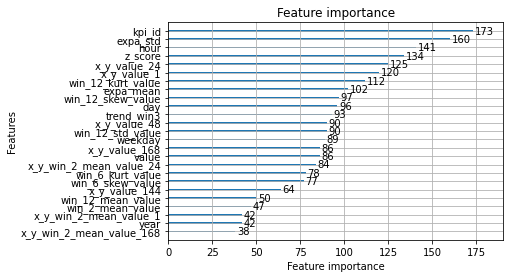

In [ ]:
lgb.plot_importance(clf, max_num_features=25)

In [ ]:
train_data = lgb.Dataset(board_train_X, label=board_train_Y)

In [ ]:
boaGBM_pre = clf.predict(board_test_X)
pre1 = pd.DataFrame(boaGBM_pre)
pre1[pre1>0.75] = 1
pre1[pre1<=0.75] = 0
f1_score(board_test_Y, pre1)

0.8729641693811075

In [ ]:
confusion_matrix(board_test_Y,pre1)

array([[4867,   21],
       [  18,  134]])

XGBOOST

In [ ]:
from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance

In [ ]:
xgb_parrams={
    'booster':'gbtree',
    'objective':'binary:logistic',
    'eval_metric':'error',
     'colsample_bytree': 0.30801698649621306,
     'gamma': 0.27969503858326235,
     'learning_rate': 0.04341140878653162,
     'max_depth': 7,
     'reg_alpha': 0.38161740307145836,
     'reg_lambda': 0.3109582304218081,
     'min_child_weight ': 3,
     'subsample': 0.8,
     'random_seed': 2022,
            }
xgb2 = XGBClassifier(**xgb_parrams)

In [ ]:
xgb2.fit(cycle_train_X, cycle_train_Y)

XGBClassifier(colsample_bytree=0.30801698649621306, eval_metric='error',
              gamma=0.27969503858326233, learning_rate=0.04341140878653162,
              max_depth=7, min_child_weight =3, random_seed=2022,
              reg_alpha=0.38161740307145836, reg_lambda=0.3109582304218081,
              subsample=0.8)

In [ ]:
cycXGB_pre = xgb2.predict_proba(cycle_test_X)[:,1]
pre1 = pd.DataFrame(cycXGB_pre)
pre1[pre1>0.65] = 1
pre1[pre1<=0.65] = 0
f1_score(cycle_test_Y, pre1)

0.6582809224318658

In [ ]:
print(xgb2.feature_importances_)

0.00687873


In [ ]:
confusion_matrix(cycle_test_Y,pre1)

array([[6904,   78],
       [  85,  157]])

In [ ]:
xgb2.fit(board_train_X, board_train_Y)

XGBClassifier(colsample_bytree=0.30801698649621306, eval_metric='error',
              gamma=0.27969503858326233, learning_rate=0.04341140878653162,
              max_depth=7, min_child_weight =3, random_seed=2022,
              reg_alpha=0.38161740307145836, reg_lambda=0.3109582304218081,
              subsample=0.8)

In [ ]:
boaXGB_pre = xgb2.predict_proba(board_test_X)[:,1]
pre1 = pd.DataFrame(boaXGB_pre)
pre1[pre1>0.43] = 1
pre1[pre1<=0.43] = 0
f1_score(board_test_Y, pre1)

0.9198606271777003

In [ ]:
confusion_matrix(board_test_Y,pre1)

array([[4885,    3],
       [  20,  132]])

NGBOOST


In [ ]:
pip install --upgrade ngboost

     |████████████████████████████████| 348 kB 8.2 MB/s 
     |████████████████████████████████| 55 kB 3.1 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=4a9bea1689d099d37d6eb5d7a08dcb69571dac90041363539d0872dc9b44a00b
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma


In [ ]:
from ngboost import NGBClassifier, NGBRegressor
from ngboost.distns import k_categorical, Bernoulli, LogNormal
from ngboost.distns import Exponential, Normal
from ngboost.scores import LogScore, CRPScore

In [ ]:
np.random.seed(12345)
ngb = NGBClassifier(Dist=k_categorical(2), Score=LogScore,learning_rate=0.04, n_estimators=1000, verbose=True,random_state=12345)
ngb.fit(cycle_train_X.astype('int64'), cycle_train_Y.astype('int64'))

[iter 0] loss=0.6921 val_loss=0.0000 scale=4.0000 norm=8.0000
[iter 100] loss=0.1594 val_loss=0.0000 scale=1.0000 norm=1.3645
[iter 200] loss=0.1436 val_loss=0.0000 scale=0.0001 norm=0.0002
[iter 300] loss=0.1436 val_loss=0.0000 scale=0.0001 norm=0.0002
[iter 400] loss=0.1430 val_loss=0.0000 scale=0.0001 norm=0.0002
[iter 500] loss=0.1430 val_loss=0.0000 scale=0.0001 norm=0.0002
[iter 600] loss=0.1430 val_loss=0.0000 scale=0.0001 norm=0.0002
[iter 700] loss=0.1430 val_loss=0.0000 scale=0.0001 norm=0.0002
[iter 800] loss=0.1430 val_loss=0.0000 scale=0.0001 norm=0.0002
[iter 900] loss=0.1430 val_loss=0.0000 scale=0.0001 norm=0.0002


NGBClassifier(learning_rate=0.04, n_estimators=1000,
              random_state=RandomState(MT19937) at 0x7F91E1708490)

In [ ]:
aaa = np.delete(board_kpi_train.columns, 1)
aaa

Index(['value', 'year', 'month', 'day', 'weekday', 'hour', 'weekend',
       'daylight', 'kpi_id', 'win_2_mean_value', 'win_3_mean_value',
       'win_6_mean_value', 'win_6_std_value', 'win_6_skew_value',
       'win_6_kurt_value', 'win_6_q25_value', 'win_6_q50_value',
       'win_6_q75_value', 'win_12_mean_value', 'win_12_std_value',
       'win_12_skew_value', 'win_12_kurt_value', 'win_12_q25_value',
       'win_12_q50_value', 'win_12_q75_value', 'x_y_value_1', 'x_y_value_24',
       'x_y_value_48', 'x_y_value_144', 'x_y_value_168',
       'x_y_win_2_mean_value_1', 'x_y_win_2_mean_value_24',
       'x_y_win_2_mean_value_48', 'x_y_win_2_mean_value_144',
       'x_y_win_2_mean_value_168', 'x_y_win_3_mean_value_1',
       'x_y_win_3_mean_value_24', 'x_y_win_3_mean_value_48',
       'x_y_win_3_mean_value_144', 'x_y_win_3_mean_value_168', 'expa_mean',
       'expa_std', 'win_3_mean', 'trend_win3', 'z_score'],
      dtype='object')

Text(0.5, 1.0, 'loc param')

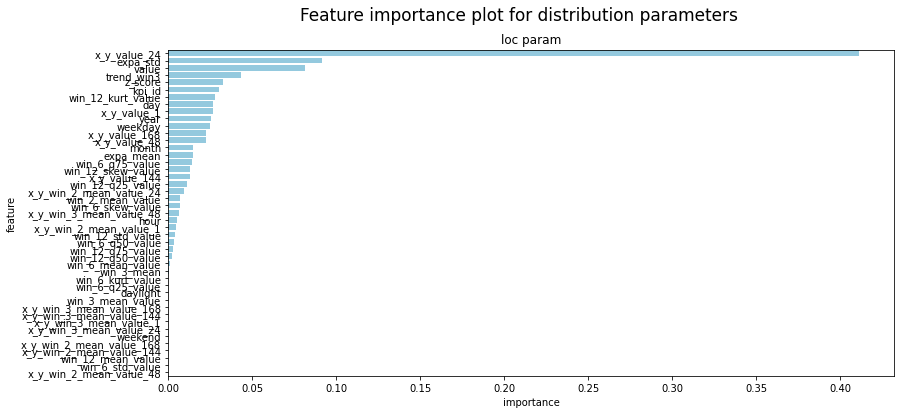

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance_loc = ngb.feature_importances_[0]

df_loc = pd.DataFrame({'feature':board_train_X.columns,
                       'importance':feature_importance_loc})\
    .sort_values('importance',ascending=False)

fig, ax1 = plt.subplots(1, 1, figsize=(13,6))
fig.suptitle("Feature importance plot for distribution parameters", fontsize=17)
sns.barplot(x='importance',y='feature',ax=ax1,data=df_loc, color="skyblue").set_title('loc param')

In [ ]:
cycNgb_pre = ngb.predict_proba(cycle_test_X)[:,1]#cycNgb_pre = ngb.predict(cycle_test_X)
pre1 = pd.DataFrame(cycNgb_pre)
pre1[pre1>0.906] = 1
pre1[pre1<=0.906] = 0
f1_score(cycle_test_Y, pre1) #0.6382978723404257

0.6416666666666667

In [ ]:
confusion_matrix(cycle_test_Y,pre1)

array([[6898,   84],
       [  88,  154]])

In [ ]:
ngb = NGBClassifier(Dist=k_categorical(2), Score=LogScore,learning_rate=0.04, n_estimators=1000, verbose=True,random_state=12345)
ngb.fit(board_train_X.astype('int64'), board_train_Y.astype('int64'))

[iter 0] loss=0.0661 val_loss=0.0000 scale=0.5000 norm=1.0000
[iter 100] loss=0.0079 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 200] loss=0.0079 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 300] loss=0.0079 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 400] loss=0.0079 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 500] loss=0.0079 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 600] loss=0.0079 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 700] loss=0.0079 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 800] loss=0.0079 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 900] loss=0.0079 val_loss=0.0000 scale=0.0001 norm=0.0001


NGBClassifier(learning_rate=0.04, n_estimators=1000,
              random_state=RandomState(MT19937) at 0x7F91E3CDE5A0)

In [ ]:
boaNgb_pre = ngb.predict_proba(board_test_X)[:,1]#cycNgb_pre = ngb.predict(cycle_test_X)
pre1 = pd.DataFrame(boaNgb_pre)
pre1[pre1>0.2] = 1
pre1[pre1<=0.2] = 0
f1_score(board_test_Y, pre1) #0.6382978723404257

0.923611111111111

In [ ]:
confusion_matrix(board_test_Y,pre1)

array([[4885,    3],
       [  19,  133]])

FINAL STAGE

In [ ]:
cyc_total_pre = cycCat_pre*0.4 + cycGBM_pre*0.3 + cycXGB_pre*0.3
cyc_pre1 = pd.DataFrame(cyc_total_pre)
cyc_pre1[cyc_pre1>0.65] = 1
cyc_pre1[cyc_pre1<=0.65] = 0
f1_score(cycle_test_Y, cyc_pre1)

0.6801007556675063

In [ ]:
confusion_matrix(cycle_test_Y,cyc_pre1)

array([[6962,   20],
       [ 106,  136]])

In [ ]:
boa_total_pre = boaCat_pre*0.4 + boaGBM_pre*0.3 + boaXGB_pre*0.3
boa_pre1 = pd.DataFrame(boa_total_pre)
boa_pre1[boa_pre1>0.39] = 1
boa_pre1[boa_pre1<=0.39] = 0
f1_score(board_test_Y, boa_pre1)

0.9527027027027027

In [ ]:
confusion_matrix(board_test_Y,boa_pre1)

array([[4885,    3],
       [  11,  141]])

In [ ]:
total_test = pd.concat([board_test_Y,cycle_test_Y, zero_kpi_test.label], axis=0)
total_pre = pd.concat([boa_pre1, cyc_pre1, pd.DataFrame(zero_pre)],axis=0)

In [ ]:
f1_score(total_test, total_pre)  #final_test

0.7965367965367967

In [ ]:
confusion_matrix(total_test,total_pre)

array([[16719,    23],
       [  118,   276]])

FINAL STAGE2

In [ ]:
cyc_total_pre = cycCat_pre*0.25 + cycGBM_pre*0.1 + cycXGB_pre*0.25+cycNgb_pre*0.4
cyc_pre1 = pd.DataFrame(cyc_total_pre)
cyc_pre1[cyc_pre1>0.34] = 1
cyc_pre1[cyc_pre1<=0.34] = 0
f1_score(cycle_test_Y, cyc_pre1)

0.6805293005671077

In [ ]:
confusion_matrix(cycle_test_Y,cyc_pre1)

array([[6875,  107],
       [  62,  180]])

In [ ]:
boa_total_pre = boaCat_pre*0.25 + boaGBM_pre*0.1 + boaXGB_pre*0.25+boaNgb_pre*0.4
boa_pre1 = pd.DataFrame(boa_total_pre)
boa_pre1[boa_pre1>0.32] = 1
boa_pre1[boa_pre1<=0.32] = 0
f1_score(board_test_Y, boa_pre1)

0.9530201342281879

In [ ]:
confusion_matrix(board_test_Y,boa_pre1)

array([[4884,    4],
       [  10,  142]])

In [ ]:
total_test = pd.concat([board_test_Y,cycle_test_Y, zero_kpi_test.label], axis=0)
total_pre = pd.concat([boa_pre1, cyc_pre1, pd.DataFrame(zero_pre)],axis=0)

In [ ]:
f1_score(total_test, total_pre)  #final_test

0.7787182587666264

In [ ]:
confusion_matrix(total_test,total_pre)

array([[16631,   111],
       [   72,   322]])

PLOT

In [ ]:
def createLabels(data):                   # 自定義函數，為引用plusone團隊
    for item in data:
        height = item.get_height()
        plt.text(
            item.get_x()+item.get_width()/2., 
            height*1.05, 
            '%d' % int(height),
            ha = "center",
            va = "bottom",
        )

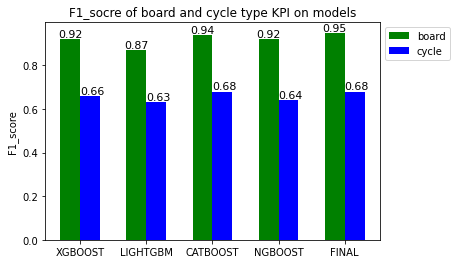

In [ ]:
plt.rcParams['figure.figsize']=(6.0,4.0)
models = ['XGBOOST', 'LIGHTGBM', 'CATBOOST', 'NGBOOST', 'FINAL']
board_f1 = [0.92, 0.87, 0.94, 0.92, 0.95]
cycle_f1 = [0.66, 0.63 ,0.68, 0.64, 0.68]
x = np.arange(len(models))
width = 0.3
plt.bar(x, board_f1, width, color = 'green', label = 'board')
plt.bar(x+width, cycle_f1, width, color = 'blue', label = 'cycle')
plt.xticks(x + width/2, models)
plt.ylabel('F1_score')
plt.title('F1_socre of board and cycle type KPI on models')
for a,b in zip(x,board_f1):  
 plt.text(a, b, '%.2f' % b, ha='center', va= 'bottom',fontsize=11)  
for a,b in zip(x,cycle_f1):  
 plt.text(a+width+0.03, b, '%.2f' % b, ha='center', va= 'bottom',fontsize=11) 
plt.legend(bbox_to_anchor=(1,1), loc='upper left')


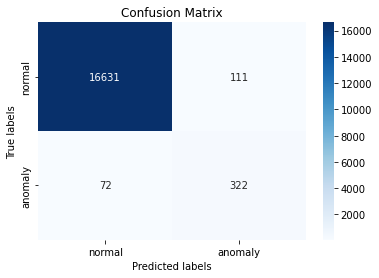

In [ ]:
ax= plt.subplot()
cm = np.array([[16631,   111],
       [   72,   322]])
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['normal', 'anomaly']); ax.yaxis.set_ticklabels(['normal', 'anomaly']);